In [85]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import sparse
from scipy import stats

import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KernelDensity
from sklearn.metrics import label_ranking_loss

import pandas as pd

from tqdm import tqdm_notebook
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import copy

print('Pandas is:', pd.__version__)
print('Numpy is:', np.__version__)
print('Matplot is:', matplotlib.__version__)
print('Scipy is:', scipy.__version__)
print('Sklearn is:', sklearn.__version__)
print('RDKit is:', rdkit.__version__)

Pandas is: 0.24.2
Numpy is: 1.16.4
Matplot is: 3.1.0
Scipy is: 1.3.0
Sklearn is: 0.21.2
RDKit is: 2019.03.2



# The missing label problem

__Virtual screening is a multilabel learning problem__. This means that each input ligand can have multiple associated protein labels. In contrast, there exist multi-class problems that are _not_ multilabel: in those paradigms, each input can be only one of many classifications.

An example of multilabel learning is image classification. Photographs can be labelled with potentially hundreds of things - colours, animal / plant species, car brands, weather, time of day, food types, texture, furniture, and so on. But generating labelled datasets for machine learning is expensive and time consuming, so usually people are interested in just a few labels. This means the __label annotation is incomplete__. So it is with ChEMBL - it's expensive to test every chemical against every protein, so there are a tonne of missing labels. Not only is this unsatisfactory in that sklearn interprets every missing interaction as an explicit negative, but it may actually rank good hits poorly during production runs.


The multilabel learning problem has a growing literature (see [1] and the authors other papers for a start, or [2] for a nice package to perform multilabel analysis). We stick to binary relevance to avoid complicating. However, __we can address the missing labels problem__. We were inspired by the approach taken in [3], which uses the correlation between similar labels to imply new labels. Importantly it does not rely on the chemical structures or fingerprints at all, just the label graph, but it does subsequently improve performance as judged by the virtual screening bootstrapper.



[1]Sechidis, K., Tsoumakas, G., & Vlahavas, I. (2011, September). On the stratification of multi-label data. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 145-158). Springer, Berlin, Heidelberg.

[2]http://scikit.ml/index.html

[3] Tan, Q., Yu, Y., Yu, G., & Wang, J. (2017). Semi-supervised multi-label classification using incomplete label information. Neurocomputing, 260, 192-202.

First, load up the data. Then observe how many ligands have multiple labels.

In [5]:
x = sparse.load_npz('../TheData/x_norm_sparse.npz')
y = sparse.load_npz('../TheData/y.npz')

x = np.array(x.todense())
y = np.array(y.todense())
allSmiles = pd.read_csv('../TheData/allSmiles.csv', header=None)
targetNames = pd.read_csv('../TheData/targetNames.csv', header=None)

(0, 1)

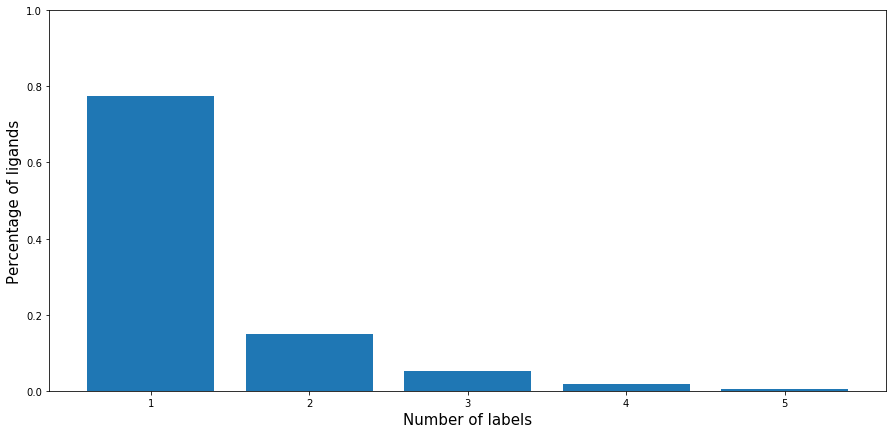

In [6]:
#number of multiple label examples:
npsum =np.sum(y, axis=1)
n_labels = list()
n_ligands = list()

for count in range(1, 6):
    n_labels.append(count)
    n_ligands.append(len(np.where(npsum==count)[0]))
    

ax = plt.axes()
ax.figure.set_size_inches(15,7)
ax.set_xticks(range(1,6))
ax.set_ylabel('Percentage of ligands', fontsize=15)
ax.set_xlabel('Number of labels', fontsize=15)
ax.bar(n_labels, np.array(n_ligands)/len(x))
ax.set_ylim(0,1)

## Label propagation

More than 20% of the ligands in our dataset have multiple labels. We can learn similarities between protein binding sites from these ligands by asking the question "What protein labels consistently occur together?". This might help fill in gaps by implying new labels. Below shows how correlated some protein labels are with each other. It iterates through every ligand and records the number of times two proteins occur in the same ligand. The x and y axes are just ID numbers for each protein target, and the heatmap shows the degree of co-occurring ligands between them. __Some proteins have a whopping 80% of co-occurring ligands!__

In [7]:
import itertools

def makeCorrelations(y_in):
    num_lines = len(y_in)
    tot_instances = np.sum(y_in, axis=0)
    L = np.zeros([y_in.shape[1], y_in.shape[1]])

    for row in y_in:
        if np.sum(row)>1:
            for j,k in itertools.permutations(np.where(row==1)[0], 2):
                L[j][k] += (1)/(tot_instances[k])
                
    return L

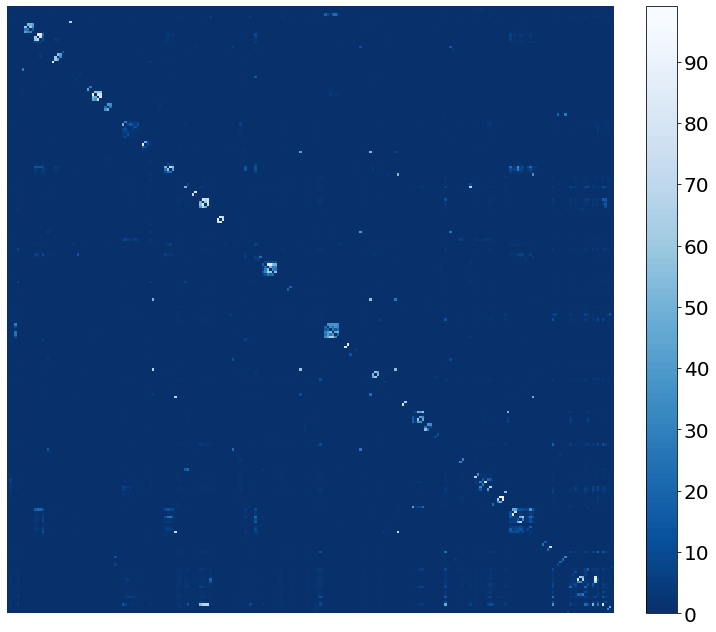

In [10]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

L = makeCorrelations(y)

fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('Blues_r')
cmap.set_bad('w')

ax.figure.set_size_inches(12,12)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.45)
im = ax.imshow(L*100, cmap=cmap, origin='upper')

ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])


cbar = fig.colorbar(im, cax=cax, orientation='vertical', boundaries=np.arange(100))
cbar.ax.tick_params(labelsize=20)

ax.figure.savefig('figure_2a_heatmap.png')

Visualising some high-correlation protein pairs shows that many are closely related, phylogenetically speaking. As a result they likely have similar shaped binding sites.

As an aside, this also suggests something like ['Dirty-Cat'](https://dirty-cat.github.io/stable/), which merges categories based on string similarity, might be useful.

In [12]:
prot1 = list()
prot2 = list()
corrs = list()
##Fetching high-correlation pairs:
top_corr = np.dstack(np.unravel_index(np.argsort(-L.ravel()), (L.shape[0], L.shape[0])))[0]
count=0
for jump in np.random.choice(100, 10):
    j,k = top_corr[count]
    prot1.append(targetNames[0].iloc[j])
    prot2.append(targetNames[0].iloc[k])
    corrs.append(100*np.around(L[j][k],2))
    count+=jump
    
pairs = pd.DataFrame(columns=['Protein Label 1', 'Protein Label 2', '% Correlation'])
#pairs.columns=['Protein1', 'Protein2', 'Correlation']
pairs['Protein Label 1']=prot1
pairs['Protein Label 2']=prot2
pairs['% Correlation']=corrs
from IPython.display import display, HTML
display(HTML(pairs.to_html(index=False)))
#pairs


Protein Label 1,Protein Label 2,% Correlation
Serine/threonine-protein kinase PIM1,Serine/threonine-protein kinase PIM2,97.0
Muscarinic acetylcholine receptor M2,Muscarinic acetylcholine receptor M3,53.0
Adenosine A3 receptor,Adenosine A1 receptor,42.0
Matrix metalloproteinase-2,Matrix metalloproteinase-1,32.0
Tyrosine-protein kinase SRC,Tyrosine-protein kinase ABL,20.0
PI3-kinase p110-gamma subunit,PI3-kinase p110-alpha subunit,18.0
Matrix metalloproteinase 8,Matrix metalloproteinase 13,15.0
Alpha-1a adrenergic receptor,Histamine H1 receptor,10.0
Tyrosine-protein kinase TIE-2,Tyrosine-protein kinase LCK,9.0
Histamine H1 receptor,Alpha-2a adrenergic receptor,9.0


__This correlation matrix can be used as a classifier__ without even looking at the chemical fingerprints. Essentially this is using the properties of a large directed graph, with ligand nodes pointing to label nodes, to predict missing links. Link prediction in large graphs is a field of it's own and is particularly useful when there's no easy vector featurization of the underlying nodes. We do already have molecular fingerprints, but link prediction is still a very effective way to fill in the label set, as seen below.

The below samples through some the known positive interactions, and __uses the co-occurrence graph to predict the probability of each known interaction occurring, as if it were previously unknown__. This is compared to the probability of a 'negative'. Since we suspect some proportion of negatives are actually positives that haven't been confirmed yet, we report the ranking loss.


---


As an example of this: if TargetA has 80% correlation with TargetB, then we can say that ligands with an interaction at TargetB, but are untested at TargetA, have an 80% probability of also binding A. We can set the threshold for a probability becoming a hit at any value we like. 

Then, for each ligand, the total probability of binding a given target is one minus the products of the correlations of all the other bound targets. This is the same as asking "if I roll 10 dice, what is the probability that I roll a single 6?", which is 1- the probability that NONE of them are a six. 

p(no sixes) = 1 - (5/6)^10

p(no sixes) = 0.838

In future this might be improved by taking into account dependence relations between targets. But without some clever approach, a bayesian network of this size (243 variables) is too large.

In [92]:
from sklearn.metrics import label_ranking_loss

# get ligands with more than one label.
# Because you can't use the correlation matrix when you've removed the only known positive.
multiple_labels = np.sum(y,axis=1)>1

#this removes the influence of each ligand individually from the co-occurrence graph,
#In theory this prevents bias, but it is so small it is not detectible.
def subtractLigand(L, row, tot_instances):
    P = copy.copy(L) #don't want to change the values in L or it will change over time. 
                    #take a copy each time we want to subtract a ligand, to keep L constant.
    for j,k in itertools.permutations(np.where(row==1)[0], 2):
        P[j][k] -= (1)/(tot_instances[k])  
    return 1-P

tot_instances = np.sum(y, axis=0)

trials=1000

rloss = list()
for idx in np.random.choice(multiple_labels.nonzero()[0], trials, replace=False):
    print(idx,end='\r')
    labels = y[idx]
    L1 = subtractLigand(L, y[idx], tot_instances) #remove influence of this ligand on the correlation matrix:
    ones = np.where(labels==1)[0]
    zeros = np.where(labels==0)[0]
    
    scores = np.zeros(labels.shape[0])
    for o in ones:
        labels = copy.copy(y[idx])
        labels[o]=0
        probs_pos = 1-np.prod(L1[o][labels==1])
        scores[o]=probs_pos
    for z in zeros:
        labels = copy.copy(y[idx])
        probs_pos = 1-np.prod(L1[z][labels==1])
        scores[z]=probs_pos
    rloss.append(label_ranking_loss([labels], [scores]))

print('##############################')
print('### Ranking loss is: %s ###' % (np.around(np.mean(rloss), 3)))
print('##############################')


##############################
### Ranking loss is: 0.012 ###
##############################


In [93]:
np.median(rloss)

0.002074688796680498

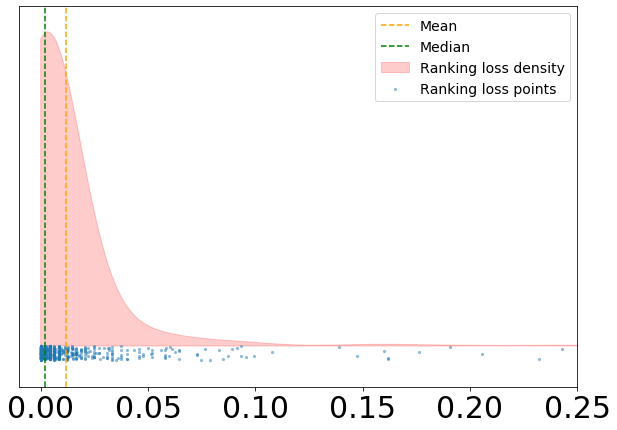

In [90]:
from sklearn.neighbors import KernelDensity
def plotKDE(data, ax, label, c='red', bw=0.025):
    bw=bw
    kde_in = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_in.fit(np.array(data).reshape(-1,1))

    X_plot = np.linspace(0, max(data), 1000)[:, np.newaxis]
    logprob = kde_in.score_samples(X_plot.reshape(-1,1))

    ax.fill_between(X_plot[:,0], np.exp(logprob), alpha=0.2, color=c, label=label)
    
    return ax

#plt.style.use('classic')

ax = plt.axes()
ax.figure.set_size_inches(10,7)

ax = plotKDE(rloss, ax, 'Ranking loss density', 'red', bw=0.015)

#ax.set_xlabel('Ranking loss', fontsize=15)
#ax.set_ylabel('Density', fontsize=15)
ax.scatter(rloss, 
           np.random.uniform(-1,0, len(rloss)), 
           s=10, 
           c='#1f77b4',
           alpha=0.5, 
           linewidth=0,
           label='Ranking loss points')
ax.axvline(np.mean(rloss), linestyle='--',color='orange', label='Mean')
ax.axvline(np.median(rloss), linestyle='--', color='green', label='Median')
ax.legend()
ax.set_yticks([])
ax.legend(ncol=1, prop={'size': 14})
ax.tick_params(labelsize=30)
ax.set_xlim(-0.01,0.25)
ax.set_ylim(-3,25)

ax.figure.savefig('figure_2c_rloss.png',facecolor='white', edgecolor='none')




## Predicting new labels

From this, we can fill in the unknown labels in our label matrix with the probabilities of an interaction. 

Then, we create several new label matrices by setting the probability threshold at low, medium, or high probability. Probabilities above this threshold become a hit. Afterwards we will test how well the new label matrices perform using the VirtualScreeningBootstrapper. 

In [94]:

probabilities_matrix = fill_in_estimates(np.array(y, dtype='float64'),
                                    np.array(y, dtype='float64'),
                                    L)

def makeNewLabels(probabilities_matrix, threshold):
    prob2 = copy.copy(probabilities_matrix)
    prob2[prob2>=threshold]=1
    prob2[prob2<threshold]=0
    return prob2

y_dict = dict()
for threshold in [0.02, 0.05, 0.1, 0.2, 0.5, 0.9,  1]:
    y_dict[threshold] = makeNewLabels(probabilities_matrix, threshold)

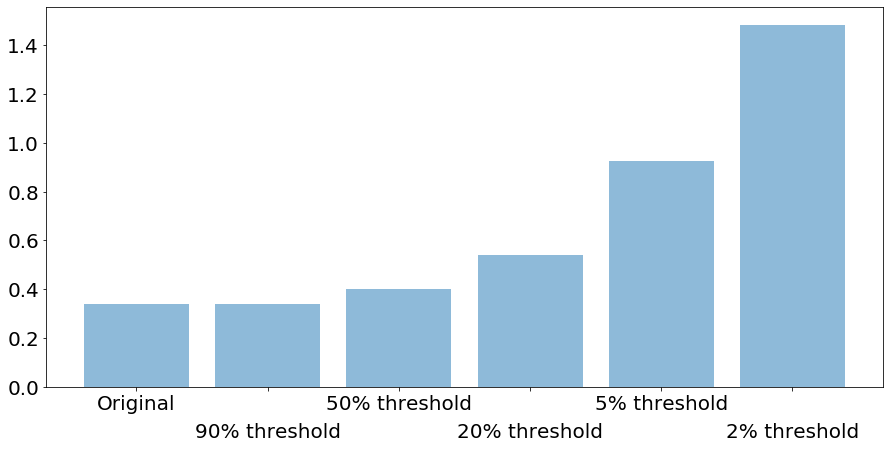

In [95]:
ax = plt.axes()
ax.figure.set_size_inches(15,7)

percents = list()
tot = y.shape[0]*y.shape[1]
for count, threshold in enumerate([1, 0.9, 0.5, 0.2, 0.05, 0.02]):
    percents.append(np.sum(y_dict[threshold])/1000000)
    

ax.set_xticks([0,1,2,3,4,5])
labels = ax.set_xticklabels(['Original', '90% threshold', '50% threshold', 
                    '20% threshold', '5% threshold',
                    '2% threshold', '1% threshold'], fontsize=12)#,rotation=45,ha='right')

for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.075)

ax.bar([0,1,2,3,4,5], percents, alpha=0.5)
ax.tick_params(labelsize=20)

ax.figure.savefig('supp_3_numligs.png')

## Do the new labels help predict the old labels?

If the new labels represent true positive interactions, then we expect the ligands come from the same distribution in chemical fingerprint space from which the original true positive ligands were drawn. The converse is that if the ligands are true negatives, then they come from the 'negative' region of chemical space, and will cause the ranking of test negatives above the ranking of test positives.

This leads to a simple hypothesis:

* If the newly predicted labels are true, the ranking loss of the known positives and negatives will become smaller. 

So we use the a variant of the virtual screening bootstrapper to test all those targets that have added ligands. In this case the test set positives are chosen only from the known positives, because it doesn't make sense to evaluate the performance on labels that have not been tested in the laboratory yet. And the test set negatives are chosen only from those labels not predicted by label propagation. 

This process took ~24 hours on 16 cores, so unfortunately is not suitable for a laptop. Here we just show the results. The code to perform the analysis is available in this directory. 

Below we show how ranking loss improves performance by using the new predicted labels to help machine learning models predict the original labels.

In [96]:
def countAdded(y, y_new):
    percentage_added = [(np.sum(y_new[:,t]) / np.sum(y[:,t])) for t in range(y.shape[1])]
    return np.array(percentage_added)

def loadResultsAtThreshold(threshold):
    performances = dict()
    for targ in range(243):
        try:
            rloss = np.load('comparison_full/target_'+str(targ)+'_threshold'+str(threshold)+'.npy')
            performances[targ]=rloss
        except:
            None
    return performances

performances_original_labels = loadResultsAtThreshold(1)

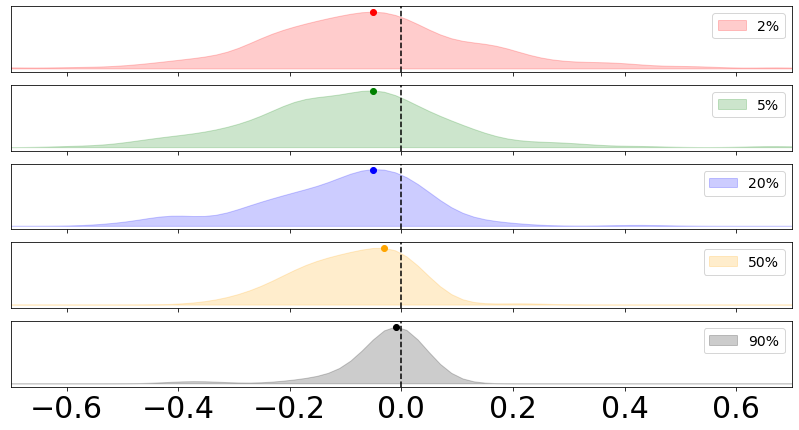

In [101]:
def plotComparisonKDE(data, ax, label, c='red', bw=0.025):
    bw=bw
    kde_in = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_in.fit(np.array(data).reshape(-1,1))

    X_plot = np.linspace(-2, 2, 200)[:, np.newaxis]
    logprob = kde_in.score_samples(X_plot.reshape(-1,1))

    ax.fill_between(X_plot[:,0], np.exp(logprob), alpha=0.2, color=c, label=label)
    
    maxPoint = np.argmax(np.exp(logprob))
    ax.scatter(X_plot[:,0][maxPoint], np.exp(logprob[maxPoint]), color=c)
    ax.axvline(0, linestyle='--', c='black')
    return ax#, X_plot[:,0][maxPoint]



fig, ax = plt.subplots(nrows=5, figsize=(14,7), sharex=True)


count = 0
for threshold, col in zip([0.02, 0.05, 0.2, 0.5, 0.9], 
                          ['red', 'green', 'blue', 'orange','black']):
    relative_performance = list()
    performances_new = loadResultsAtThreshold(threshold)
    for targ, rloss in performances_new.items():
        old = np.median(performances_original_labels[targ])
        new = np.median(performances_new[targ])
        relative_performance.append(new/old)
    _ = plotComparisonKDE(np.log10(relative_performance), ax[count], str(int(threshold*100))+'%',col, bw=0.05)
    ax[count].legend()
    ax[count].set_yticks([])
    ax[count].legend(ncol=1, prop={'size': 14})
    count+=1

#plt.xlabel('Fractional ranking loss (below 0 is better)', fontsize=15)
#plt.figlegend( loc = 'center right', labelspacing=0. )

plt.xlim(-0.7, 0.7)
plt.tick_params(labelsize=30)
fig.savefig('figure_2d_density.png',facecolor=fig.get_facecolor())
#plt.xscale('log')

0.8893212971990597
0.8038947861853383
0.7839928167971696
0.8164192835246654
0.9276384027221004


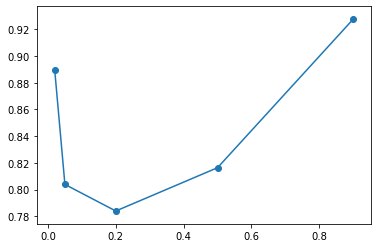

In [106]:
##Which threshold leads to the largest improvement in ranking loss? We plot here the 
##relative percentage of ranking loss of using the new labels. 

results = list()
for threshold in [0.02, 0.05, 0.2, 0.5, 0.9]:
    relative_performance = list()
    performances_new = loadResultsAtThreshold(threshold)
    for targ, rloss in performances_new.items():
        old = np.median(performances_original_labels[targ])
        new = np.median(performances_new[targ])
        relative_performance.append(new/old)
    
    print(10**np.mean(np.log10(relative_performance)))
    results.append(10**np.mean(np.log10(relative_performance)))
    
plt.plot([0.02, 0.05,  0.2, 0.5,  0.9],results)
plt.scatter([0.02, 0.05,  0.2, 0.5, 0.9],results)

These show the density of fractional ranking loss of all the targets that had additional ligands predicted, compared to the ranking loss had those new ligands not been predicted.


There is a clear answer - the new label matrices perform better- but we should note the improvement does not hold for EVERY case. Mostly the new labels improve ranking (shown by a relative reduction in ranking loss, i.e. more density to the left of the dotted line) whereas sometimes the new labels make ranking more difficult, shown by density on the right hand side of the line. There is a fair amount of spread in the data. 

Given that in each case the maximum of the distribution is to the left of 1, in each case the performance is better _on average_. Remarkably, the lower thresholds that perform best! For example, the 2% threshold has an average reduction in ranking loss by ~20%. This is despite having a four-fold increase in the number of predicted interactions. 

Apart from the obvious, what's the significance of this? Well, the original label matrix had 339,116 interactions specified. The new label matrix after propagation with a threshold of 2% has __1,481,492 interactions__. 

_That means that the improvement in classification of known positives comes with over a million new interactions for free_.

# Conclusion Pt.2

The ChEMBL database is a good resource for building QSAR models, but we should be wary that a vast majority of protein/ligand interactions have not been tested, and many machine learning approaches assume this lack of data is an explicit negative interaction.

Using properties of the label graph, i.e. with no test/train memorization bias, we showed how missing links can be predicted. This amounts to filling in the untested interactions in the label graph.

When these new labels are included as positives during model fitting, the models are better at ranking positives above negatives. Remarkably, even very liberal application of label predictions (i.e. a low threshold) performed well. This is a strong signal that many of the labels are in fact correct. 

While the models generated with these new label sets perform better than the naive label assumption, the process of label propagation is useful by itself. After all, it predicted over a million hits before a single machine learning model was trained. Of course we don't expect _every_ one of these predictions to be true, but because they improve performance on average we suspect they are _mostly_ true. As is often the case, prospective validation is best, but we offer a bonus analysis below by looking at the few known negatives from ChEMBL. 

The beauty of this approach is that practitioners can set the desired threshold to any value depending on how conservative they want to be. A simple rubric might be to set it at 20%, which has the greatest improvement in overall ranking loss. 


## BONUS: How many predicted positives are actually known negatives?
Ligands with very low potency or high EC50/IC50/etc could be considered as negatives. We downloaded all interactions with a pchembl value worse than the equivalent of 30uM (this is a pchembl of 4.52). This can give us an idea of how wrong the label propagation process is, even for the low threshold of 2%.

In [105]:
negatives =pd.read_csv('negatives.csv', sep=',', header=0)

def countAdded(y, y_new):
    percentage_added = [(np.sum(y_new[:,t]) / np.sum(y[:,t])) for t in range(y.shape[1])]
    return np.array(percentage_added)

percentage_added = countAdded(y, y_dict[0.02])

predicted_labels = y_dict[0.02]-y

numNegs = 0
for targ in (percentage_added-1).nonzero()[0]:
    print(targ, end='\r')
    nonzero = predicted_labels[:,targ].nonzero()[0]
    for i in nonzero:
        smi = allSmiles[0].iloc[i]
        if smi in negatives['canonical_smiles'].values:
            numNegs+=1

In [18]:

print('################################################')
print('### Fraction of wrong known negatives: %s ###' % (np.around(np.mean(numNegs / (np.sum(y_dict[0.02])-np.sum(y))), 3)))
print('################################################')

################################################
### Fraction of wrong known negatives: 0.001 ###
################################################


Answer: less than 0.1% of the predictions are known negatives. 